<a href="https://colab.research.google.com/github/CarolinaBRangel/Advanced-Learning/blob/main/Sky_survey_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import io

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Summary of the data and goal 

Our data here comes from the Sloan Digital Sky Survey 14. 
The data consists of 10,000 observations of space taken by the SDSS. Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar. 

Hence, our goal with this data is to train a model to classify a given object as a star, galaxy or quasar object.  

Because we have three possible classifications, our problem consists of a Multi-class classification. This means that, unlike binary classifications, the notion of normal and abnormal outcomes is absent here. Instead, here we have the classification as belonging to one on a range of classes. 

In our case, the classes are the three types of objects in space. 

Given this scenario, we must use models that predicts the possibility of a given observation belonging to each class label. Thus, we will use some different models to test for the best:



*   Naive Bayes, which classifies every value as independent of any other value. It allows us to predict a class/category, based on a given set of features, using probability;
*   Logistic regression, which focuses on estimating the probability of an event occurring based on the previous data provided;
*   Support Vector Machine, which essentially filter data into categories, which is achieved by providing a set of training examples, each set marked as belonging to one or the other of the two categories;
*   Decision trees, which uses a branching method to illustrate every possible outcome of a decision. Each node within the tree represents a test on a specific variable – and each branch is the outcome of that test;
*   Random forest, which is an ensemble learning method, combining multiple algorithms to generate better results for classification, regression and other tasks.
*   K Nearest neighbours, which estimates how likely a data point is to be a member of one group or another;
*   Extreme gradient boosting, which is a boosting algorithm based on gradient boosted decision trees algorithm. XGBoost applies a better regularization technique to reduce overfitting.









## Loading data

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['sky.csv']))

Saving sky.csv to sky (1).csv


## Data exploration

In [3]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


There is only one variable, that of class, which is an object and I will need to transform in a numeric one later. 

In [5]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


There are no missing values, meaning there will be no need to imput values.
Also, the min, max and mean within each column is not dramatically different, so I believe outliers will not be a huge issue here.

Now lets take a look at how the depened variable is classified here

In [6]:
df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

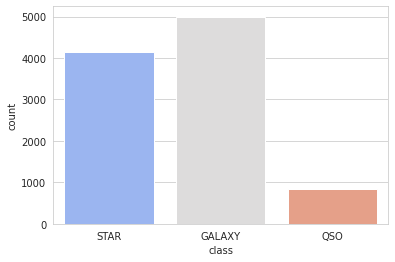

In [7]:
sns.countplot(x='class',data=df, palette='coolwarm')

49.98% of the objects are galaxies, 41.52% are stars and 8.5% are quasar objects. Therefore, we can see that the data is quite umbalaced, especially regarding the quasar objects.

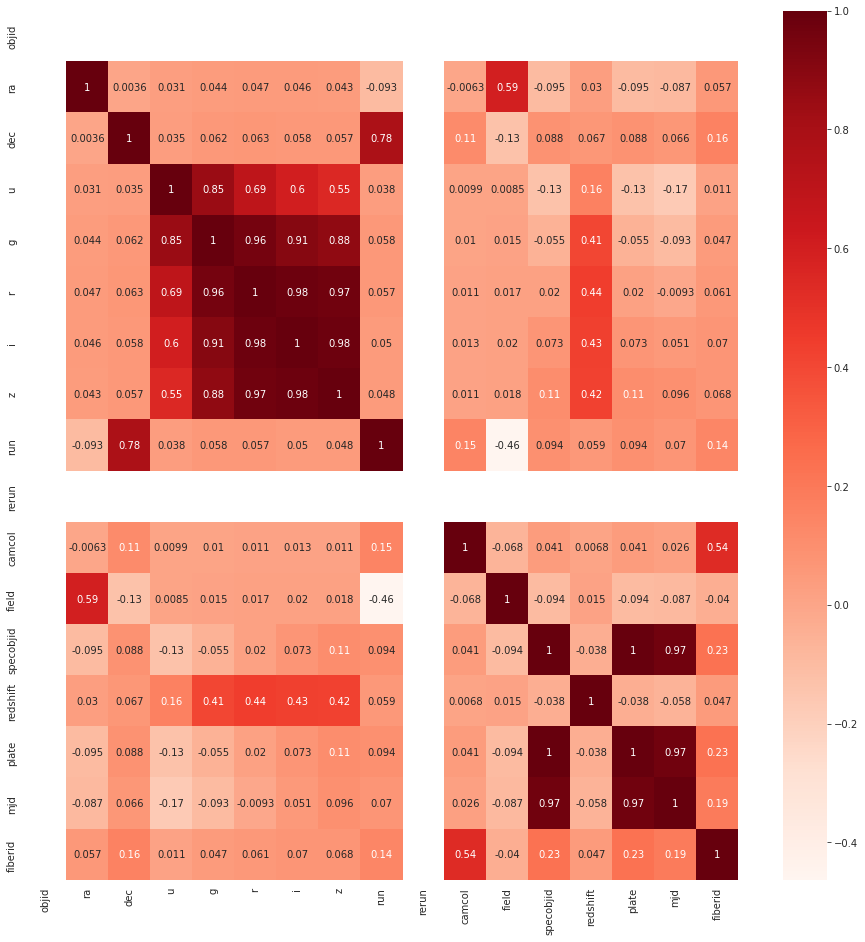

In [8]:
plt.figure(figsize=(16,16))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

COMENTAR A MATRIZ DE CORRELAÇÃO ACIMA

One variable, redshift, refers to light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum.

Reading about it online, it seems that it can be an estimate from how distant the objects in space are from earth. Thus, I will begin by looking for patterns in the redshift of each of the 3 possible classes.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1600.0)]

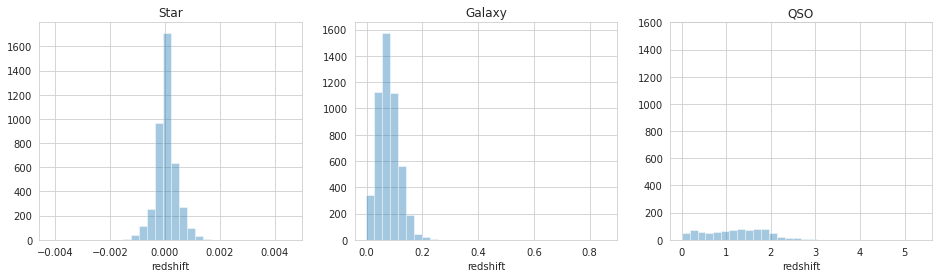

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax.set_title('QSO')
ax.set(ylim = (0, 1600))

Indeed, the redshift is different for each of the three classes.

It seems stars are closer to earth, given they have the smallest redshifts. Also, their readshift seems to be the most concentrated, with values between -0.002 and 0.002.

Quasar objects are the the most far away, with values going from quite close (0) to very far (5). 

Galaxies are all at a higher than 0 redshift, but they remain between 0 and 0.2.

The importance here is that redshift will likely be a good predictor of the class.

Other variables in the dataset refer to the different wavelengths which are used to capture the observations - the 5 bands of the telescope. It is reasonable to believe that they may be correlated amongst themselves since different bands will have different 'distance' capacities.

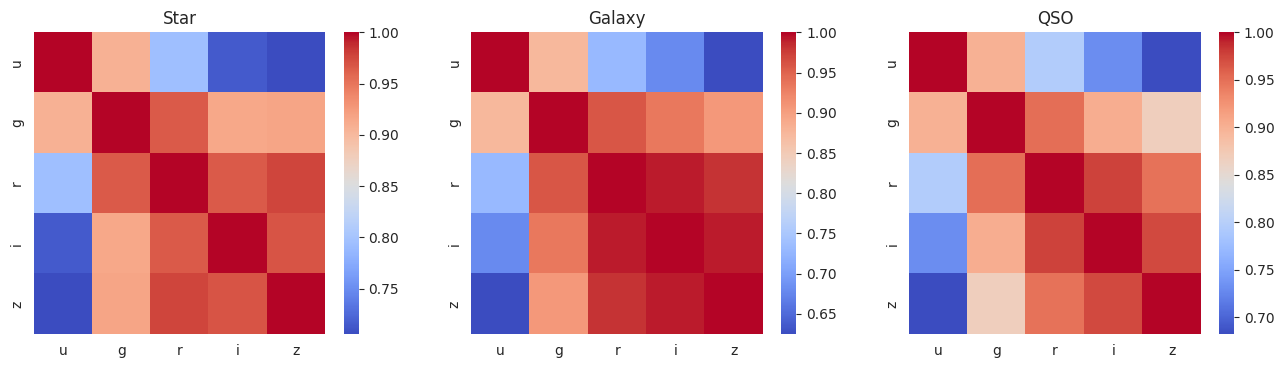

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(df[df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(df[df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(df[df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

The interesting thing is that u is less correlated with the other bands and, thus, it may be that the scope u cannot capture given the maximum distance it can reach.

Another two variables that seems to be interesting are ra and dec.

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the sky in the equatorial coordinate system.

Hence, my understaning is that they pin point where a celestial body is. Thus, they may indicate something about the classification of such bodies.

Text(0.5, 1.0, 'dec')

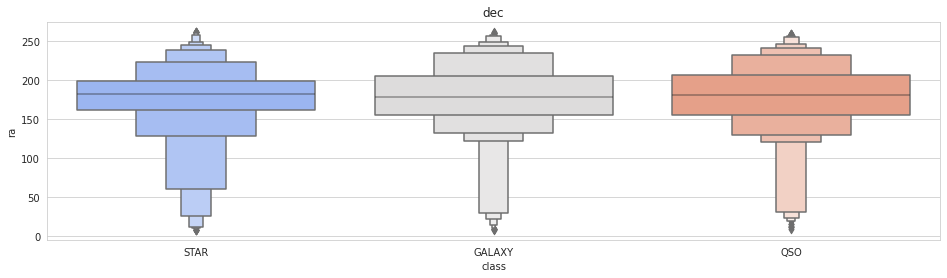

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['ra'], palette='coolwarm')
ax.set_title('dec')

# boxenplot is basically a boxplot with plots more quantiles and, thus, it is more accurate

The ra does not really tell much about each class, as the distribution is quite similar.

Text(0.5, 1.0, 'dec')

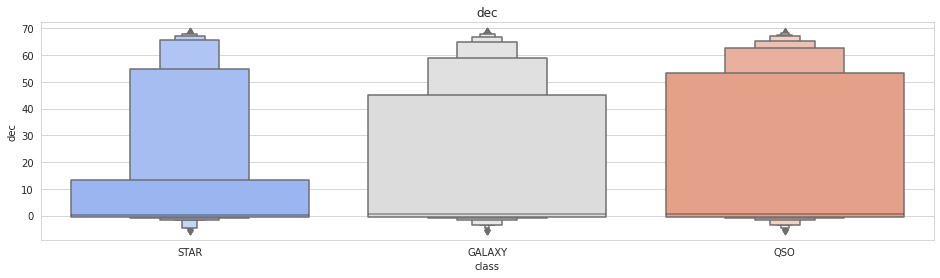

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['dec'], palette='coolwarm')
ax.set_title('dec')

The declination, however, is quite telling. 

For stares, the declination is mainly between 0 and 10, and another considerable part of the class is between 10 and 55.

Galaxys are mainly between 0 and 45, which a smaller amount between 45 and 60.

Quasar objects vary from 0 to a little over 50.

Thus, it seems the declination can also help differentiating mostly stars from galaxies and quasar objects.

But what happens when we look at them together?


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Coordinates')

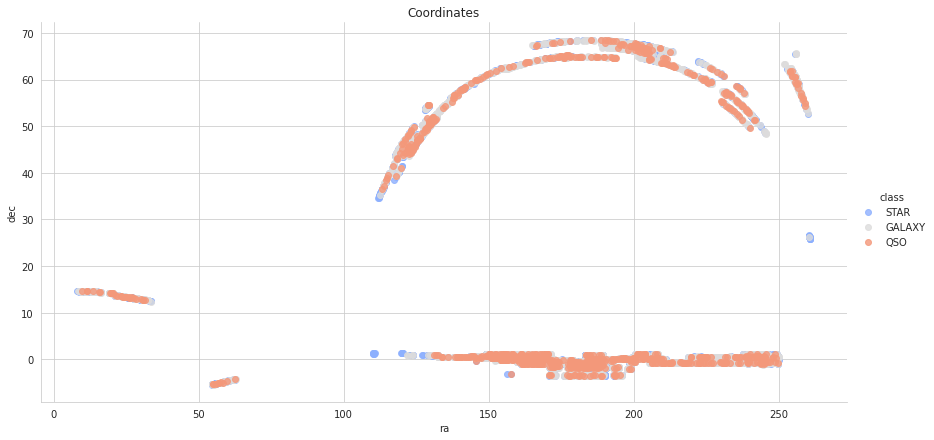

In [13]:
sns.lmplot(x='ra', y='dec', data=df, hue='class', fit_reg=False, palette='coolwarm', size=6, aspect=2)
plt.title('Coordinates')

The full coordinates are very similar for the three classes. This goes against the assumption that the declination will help differentiating stars. 

Now let's take a look at the other variables

Plate represents the serial number of large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 5000.0)]

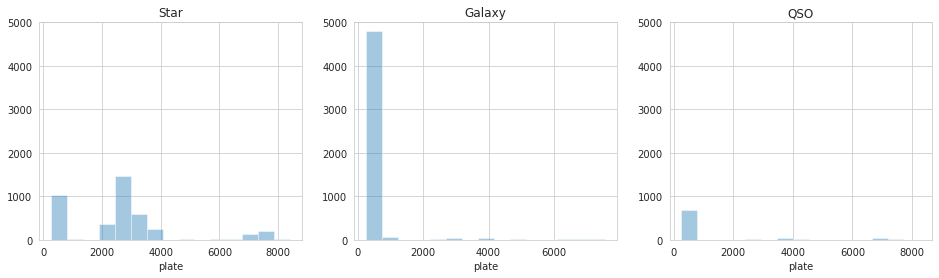

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].plate, bins = 15, ax = axes[0], kde = False)
ax.set_title('Star')
ax.set(ylim = (0, 5000))
ax = sns.distplot(df[df['class']=='GALAXY'].plate, bins = 15, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax.set(ylim = (0, 5000))
ax = sns.distplot(df[df['class']=='QSO'].plate, bins = 15, ax = axes[2], kde = False)
ax.set_title('QSO')
ax.set(ylim = (0, 5000))

There may be an effect of the plate used given galaxies and quasar objects are 'found'mainly by plates closer to 0 whereas stars are more distributed between types of plates. QSO mais parecido com estrelas - balancear os dados em escalas.

MJD indicates the date that a given piece of data (image or spectrum) was taken.

[(0.0, 1800.0)]

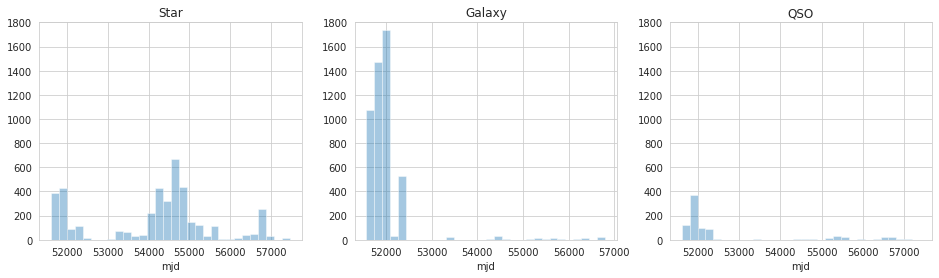

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].mjd, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax.set(ylim = (0, 1800))
ax = sns.distplot(df[df['class']=='GALAXY'].mjd, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax.set(ylim = (0, 1800))
ax = sns.distplot(df[df['class']=='QSO'].mjd, bins = 30, ax = axes[2], kde = False)
ax.set_title('QSO')
ax.set(ylim = (0, 1800))

Again, galaxies and quasar objects are more focues between 52000 and 53000 whereas star are all over the place.

[(0.0, 300.0)]

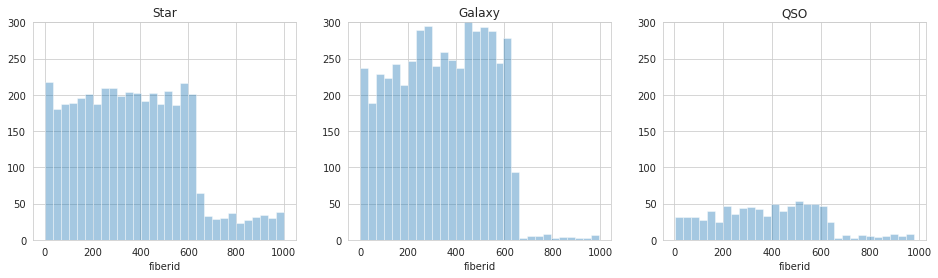

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(df[df['class']=='STAR'].fiberid, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax.set(ylim = (0, 300))
ax = sns.distplot(df[df['class']=='GALAXY'].fiberid, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax.set(ylim = (0, 300))
ax = sns.distplot(df[df['class']=='QSO'].fiberid, bins = 30, ax = axes[2], kde = False)
ax.set_title('QSO')
ax.set(ylim = (0, 300))

This last variable, fiberid, is simply the id of the optical fibers used to direct the light at the focal plane from individual objects to the slithead. 

It seems to be more equally distributed among the classes, but it is still worth to keep it, since the distance of celestial bodies mean differnt fiber optics are needed for certain distances.

From the documentation, it is noticeable that the variables 'objective indetifier' (objid and specobjid) are just the identification of each objetc used to organize the original dataset, which has no effect in classification.

Also, there are four features that describe the codes of parts of the camera that was used when the object was registered. This also does not seem to matter when attempting to classify. 

Therefore, I will remove the abovementioned variables.

In [17]:
df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'], axis=1, inplace=True)

In [18]:
df.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


## Feature selection: Exploratiom

We saw that the the 5 bands of the telescope are quite correlated to one another, even though u is a bit lower (under .80). Still, it like 'overkill' to keep the 5 variables in the dataset. 

Looking for ways to deal with this without having to simply choose one over another, I thought of Principal Component Analysis. (an example can be seen here https://www.kaggle.com/code/lucidlenn.)

In a nutsheel, n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p).

It does so by finding the q directions in which the n points vary the most (--> the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

I will use this technique. 

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
ugriz = pca.fit_transform(df[['u', 'g', 'r', 'i', 'z']])

df_p = pd.concat((df, pd.DataFrame(ugriz)), axis=1)
df_p.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
df_p.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
df_p.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,STAR,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


## Split

In [20]:
df['class'] = df['class'].replace({'STAR': 1, 'GALAXY': 2, 'QSO': 3})
df_p['class'] = df_p['class'].replace({'STAR': 1, 'GALAXY': 2, 'QSO': 3})

In [21]:
train, test = train_test_split(df, test_size = 0.3)
train_p, test_p = train_test_split(df_p, test_size = 0.3)

In [22]:
x_train = train.drop('class', 1)
y_train = train['class']

x_test = test.drop('class', 1)
y_test = test['class']

x_train_p = train_p.drop('class', 1)
y_train_p = train_p['class']

x_test_p = test_p.drop('class', 1)
y_test_p = test_p['class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


## Modelos 

Let's begin by running the models without focusing on hyperparemeters - just to see how they behave at first.

Primeiro sem o PCA

In [23]:
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    return mape

In [24]:
NVB = GaussianNB()
LGR = LogisticRegression()
SVM = SVC()
KNN = KNeighborsClassifier()
DTR = DecisionTreeClassifier(max_depth=5)
RFR =RandomForestClassifier()
XGB = XGBClassifier(n_estimators=100).fit(x_train, y_train)

model_names = list(['NVB', 'LGR', 'SVM', 'KNN', 'DTR', 'RFR', 'XGB'])
model_list = list([NVB, LGR, SVM, KNN, DTR, RFR, XGB])

In [25]:
mape_list = []
in_sample_preds = []
out_sample_preds = []
for model in model_list:
    model.fit(x_train, y_train)   
    in_sample_preds.append(model.predict(x_train))
    out_sample_preds.append(model.predict(x_test))
    mape_list.append(round(mape( y_test , model.predict(x_test)), 4))
mape_results_0 = pd.DataFrame({
    'Model': model_names,
    'MAPE': mape_list}
)
mape_results_0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Model,MAPE
0,NVB,15.0944
1,LGR,14.6556
2,SVM,14.6556
3,KNN,15.2667
4,DTR,0.6500
5,RFR,0.5222
6,XGB,0.3722


Agora com o PCA

In [26]:
NVB = GaussianNB()
LGR = LogisticRegression()
SVM = SVC()
KNN = KNeighborsClassifier()
DTR = DecisionTreeClassifier(max_depth=5)
RFR =RandomForestClassifier()
XGB = XGBClassifier(n_estimators=100).fit(x_train, y_train)

model_names = list(['NVB', 'LGR', 'SVM', 'KNN', 'DTR', 'RFR', 'XGB'])
model_list = list([NVB, LGR, SVM, KNN, DTR, RFR, XGB])

In [27]:
mape_list = []
in_sample_preds = []
out_sample_preds = []
for model in model_list:
    model.fit(x_train_p, y_train_p)   
    in_sample_preds.append(model.predict(x_train_p))
    out_sample_preds.append(model.predict(x_test_p))
    mape_list.append(round(mape(y_test_p , model.predict(x_test_p)), 4))
mape_results_1 = pd.DataFrame({
    'Model': model_names,
    'MAPE': mape_list}
)
mape_results_1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Model,MAPE
0,NVB,8.4000
1,LGR,14.8167
2,SVM,14.8167
3,KNN,15.5278
4,DTR,0.5556
5,RFR,0.2944
6,XGB,0.2333


Since the PCA inproved accuracy, I will use the dataset that contains it.

## Hyperparemeter

To identify hyperparemeters, we will devide the training set into train and validation. 

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.15, random_state=5)

### Decision tree hyperparemeters

Text(0.5, 1.0, 'Performance on Training set and Validation set')

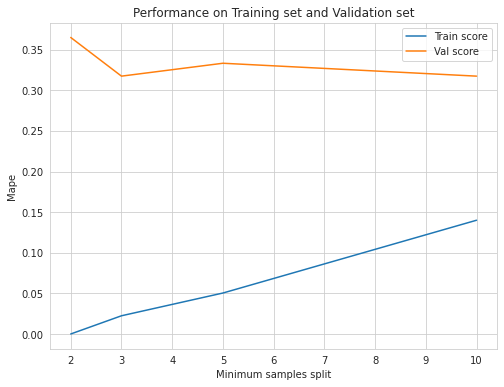

In [29]:
min_samples_split = [2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_split:
    clf = DecisionTreeClassifier(min_samples_split=i, random_state=1, min_samples_leaf=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_split, accuracy_train, label='Train score')
plt.plot(min_samples_split, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples split')
plt.ylabel('Mape')
plt.title('Performance on Training set and Validation set')

3 was chosen for the hyperparameter of min_samples_split as ir performed better on the val set.

Text(0.5, 1.0, 'Performance on Training set and Val set')

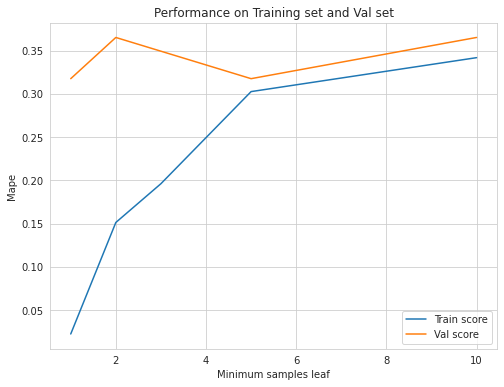

In [30]:
min_samples_leaf = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_leaf:
    clf = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_leaf, accuracy_train, label='Train score')
plt.plot(min_samples_leaf, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

3 was chosen for min samples leaf as it performed better in the val

Text(0.5, 1.0, 'Performance on Training set and Val set')

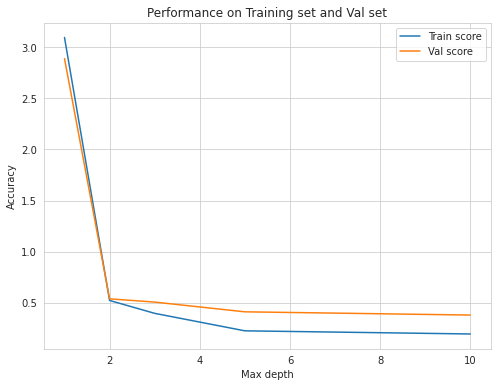

In [31]:
max_depth = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in max_depth:
    clf = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=3, max_depth = i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(max_depth, accuracy_train, label='Train score')
plt.plot(max_depth, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Performance on Training set and Val set')

In [32]:
DTR = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth = 10, random_state=1)
DTR.fit(x_train, y_train)
DTR_pred = DTR.predict(x_test_p)
print('Mape:', round(mape(y_test_p, DTR_pred), 2))

Mape: 0.4


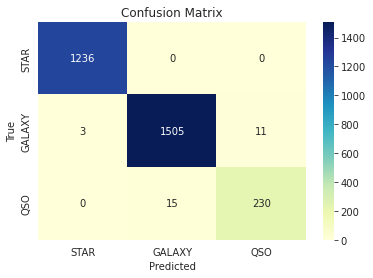

In [33]:
from sklearn.metrics import confusion_matrix

cm_DTR = confusion_matrix(y_test_p, DTR_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_DTR, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

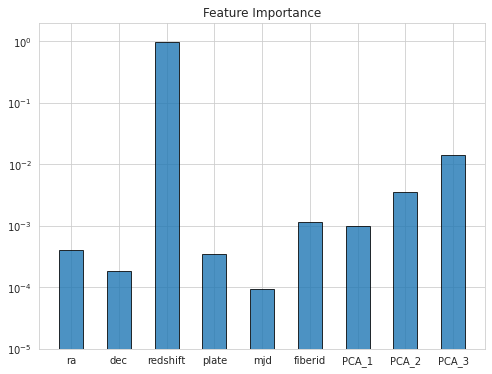

In [34]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### Random forest hyperparemeters

Text(0.5, 1.0, 'Performance on Training set and Val set')

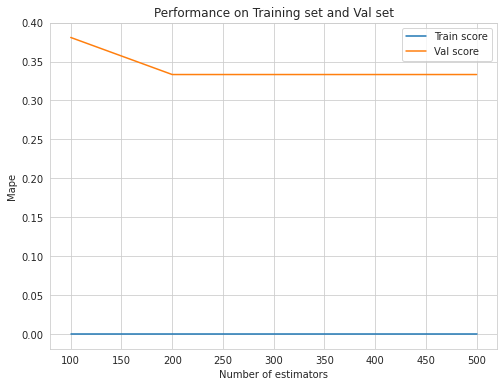

In [35]:
n_estimators = [100, 200, 300, 400, 500]
accuracy_train = []
accuracy_val = []
for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(n_estimators, accuracy_train, label='Train score')
plt.plot(n_estimators, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Number of estimators')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

100 was chosen as the pest parameter

Text(0.5, 1.0, 'Performance on Training set and Val set')

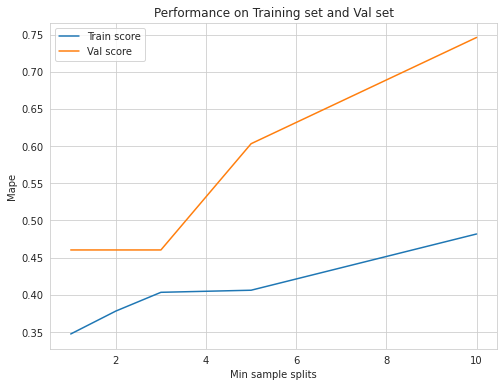

In [36]:
min_samples_split = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split= i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_split, accuracy_train, label='Train score')
plt.plot(min_samples_split, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Min sample splits')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

2 was chosen

Text(0.5, 1.0, 'Performance on Training set and Val set')

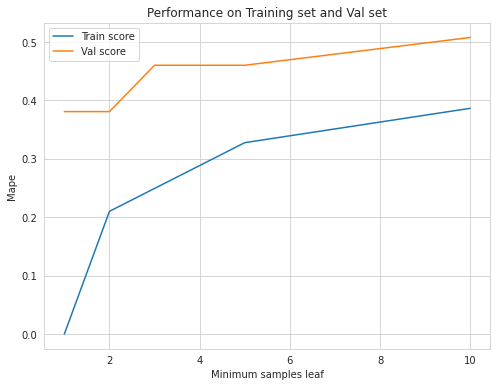

In [37]:
min_samples_leaf = [1, 2, 3, 5, 10]
accuracy_train = []
accuracy_val = []
for i in min_samples_leaf:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf=i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(min_samples_leaf, accuracy_train, label='Train score')
plt.plot(min_samples_leaf, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Mape')
plt.title('Performance on Training set and Val set')

1 was chosen

In [38]:
RFR = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf=1, random_state=1)
RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test_p)
print('Mape:', round(mape(y_test_p, RFR_pred), 2))

Mape: 0.29


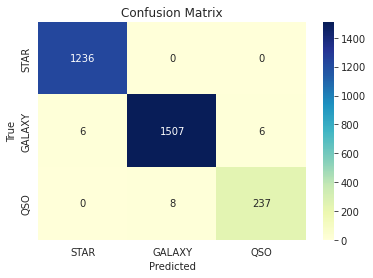

In [39]:
cm_RFR = confusion_matrix(y_test_p, RFR_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_RFR, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

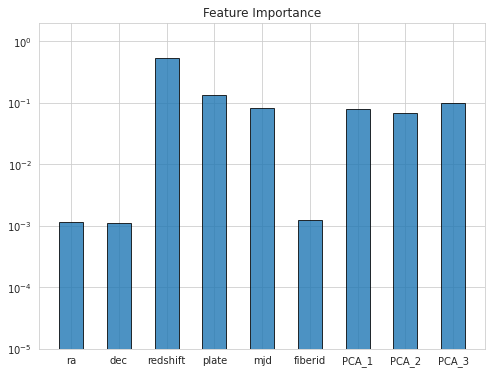

In [40]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### XGBoost

Text(0.5, 1.0, 'Performance on Training set and Validation set')

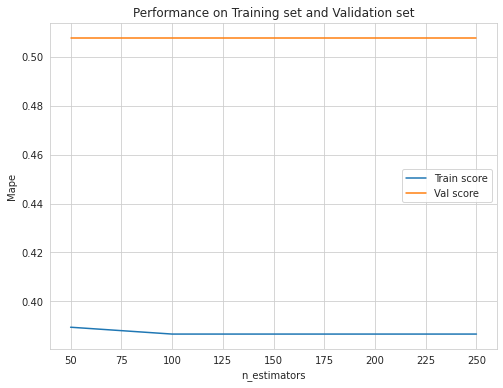

In [41]:
n_estimators = [50, 100, 150, 200, 250]
accuracy_train = []
accuracy_val = []
for i in min_samples_split:
    clf = XGBClassifier(n_estimators = i, random_state=1)
    clf.fit(x_train, y_train)
    accr = mape(y_train, clf.predict(x_train))
    accuracy_train.append(accr)
    accr = mape(y_val, clf.predict(x_val))
    accuracy_val.append(accr)
f, ax = plt.subplots(1, figsize=(8,6))
plt.plot(n_estimators, accuracy_train, label='Train score')
plt.plot(n_estimators, accuracy_val, label='Val score')
plt.legend(loc='best')
plt.xlabel('n_estimators')
plt.ylabel('Mape')
plt.title('Performance on Training set and Validation set')

In [42]:
XGB = XGBClassifier(n_estimators=250, random_state=1)
XGB.fit(x_train, y_train)
XGB_pred = XGB.predict(x_test_p)
print('Mape:', round(mape(y_test_p, XGB_pred), 2))

Mape: 0.22


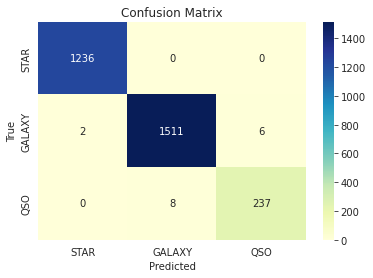

In [43]:
cm_XGB = confusion_matrix(y_test_p, XGB_pred)

labels = ['STAR', 'GALAXY', 'QSO']

ax= plt.subplot()
sns.heatmap(cm_XGB, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

Text(0.5, 1.0, 'Feature Importance')

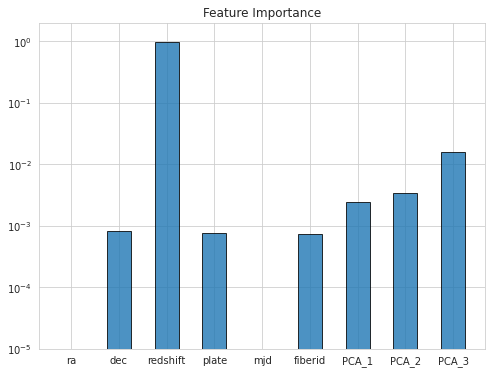

In [44]:
feature_imp = pd.DataFrame({'Feature': x_train.columns,'Importance': clf.feature_importances_})
f = plt.subplots(1, figsize=(8,6))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

### Permutation importance of the best models 

The best models were XGBoost and Gradient Boosting.

Permutation Importance judges the importance of a feature by how much it impacts model performance when it is removed.

I will use the sklearn and ELI5 library. 

In [45]:
! pip install eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


XGBoost

In [46]:
r = permutation_importance(XGB, x_test_p, y_test_p,
                           n_repeats=30,
                           random_state = 1)

xgb_importances = pd.Series(r.importances_mean, x_test_p.columns)

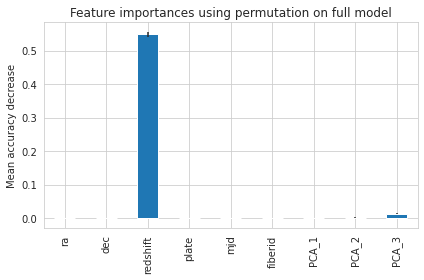

In [47]:
fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=r.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Neural Network

In [48]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from tensorflow.keras import models, layers, utils, backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical 
from matplotlib import pyplot

In [50]:
x_train = train.drop('class', 1)
y_train = train['class']

x_test = test.drop('class', 1)
y_test = test['class']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [51]:
y_train.to_numpy()
y_train = to_categorical(y_train, dtype = 'int64')

In [52]:
y_test.to_numpy()
y_test = to_categorical(y_test, dtype = 'int64')

In [53]:
model = Sequential()
model.add(Dense(50, input_shape=(11,), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

In [54]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [56]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [55]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)

ValueError: ignored

In [ ]:
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [ ]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()